**Load Data from your Google Drive**

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Enter the folder including csv files.

#**Part 1 - Data Preprocessing**

First, we import required libraries, **numpy**, **matplotlib.pyplot**, and **pandas**.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as pltdef
import itertools
from sklearn.metrics import RocCurveDisplay

tf.random.set_seed(1234)

Import the training dataset. Hint: use **read_csv** from Pandas library. 

In [3]:
dataset_train = pd.read_csv('gdrive/MyDrive/data/ECG_dataset/trainval.csv')
# dataset_valid = pd.read_csv('gdrive/MyDrive/data/ECG_dataset/train.csv')
dataset_test = pd.read_csv('gdrive/MyDrive/data/ECG_dataset/test.csv')

Show the training dataset by using **head** method.

In [4]:
# Put your codes here
dataset_train.head()

,1,0.024133,0.016065,0.044639,0.031001,-0.009473,-0.042663,-0.077283,-0.091508,-0.046113999999999995,...,0.051275,0.06124400000000001,0.053409000000000005,0.12092,0.081996,0.039526,0.073486,0.020875,-0.018836000000000002,0.030808999999999996
0,0,0.42438,0.34442,0.348130,0.340170,0.243370,0.241730,0.268780,0.27342,0.35644,...,0.526440,0.559020,0.55567,0.597270,0.570760,0.46749,0.46340,0.48188,0.43219,0.39453
1,0,1.52950,1.77660,1.936700,1.840200,1.800000,1.724900,1.405800,1.00880,0.72472,...,0.169600,0.126170,0.25830,0.238590,0.465590,0.64028,0.72765,0.86787,1.05860,1.29530
2,0,1.28650,1.04990,0.793600,0.473590,0.111730,-0.054857,-0.062095,-0.12075,-0.10301,...,0.966370,1.106500,1.09190,1.302600,1.572700,1.73370,1.74060,1.71170,1.57930,1.51410
3,1,-0.17540,-0.12192,-0.053532,-0.024293,0.022917,0.116440,0.187040,0.24071,0.31434,...,-0.234150,-0.248470,-0.17759,-0.223010,-0.277270,-0.23328,-0.25261,-0.26422,-0.17639,-0.15493
4,0,0.17394,0.14885,0.178910,0.237310,0.276120,0.398650,0.463010,0.47182,0.55540,...,0.046535,0.001148,-0.00753,0.008211,-0.028456,0.04728,0.10666,0.16788,0.10543,0.20467


In [5]:
transformed_df = {"X_train": [], "Y_train": [], "X_test": [], "Y_test": []}
transformed_df["X_train"] = dataset_train.drop("1", axis=1)
transformed_df["Y_train"] = dataset_train["1"]

transformed_df["X_test"] = dataset_train.drop("1", axis=1)
transformed_df["Y_test"] = dataset_train["1"]

In [6]:
X_train, Y_train = np.array(transformed_df["X_train"]), np.array(transformed_df["Y_train"])
X_test, Y_test = np.array(transformed_df["X_test"]), np.array(transformed_df["Y_test"])

In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
Y_train = np.asarray(Y_train).astype('float32').reshape((-1,1))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
Y_test = np.asarray(Y_test).astype('float32').reshape((-1,1))

In [8]:
X_train.shape

(1621, 140, 1)

In [9]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [10]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}%".format(cm[i, j] * 100),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#**Part 2 - Building the RNN stacked lstm with dropout regularization to prevent overfitting**

# Simple RNN

In [24]:
model = keras.Sequential([
    keras.layers.SimpleRNN(units=50, return_sequences= True),
    keras.layers.Dropout(0.2),
    keras.layers.SimpleRNN(units=50, return_sequences= True),
    keras.layers.Dropout(0.2),
    keras.layers.SimpleRNN(units=50, return_sequences= True),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.build(X_train.shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (1621, 140, 50)           2600      
                                                                 
 dropout_6 (Dropout)         (1621, 140, 50)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (1621, 140, 50)           5050      
                                                                 
 dropout_7 (Dropout)         (1621, 140, 50)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (1621, 140, 50)           5050      
                                                                 
 dropout_8 (Dropout)         (1621, 140, 50)           0         
                                                                 
 flatten_2 (Flatten)         (1621, 7000)             

In [25]:
callback = keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

history_rnn = model.fit(x=X_train,y=Y_train, validation_split=0.20, batch_size=32, epochs=30, verbose=2, callbacks=[callback])

Epoch 1/30
41/41 - 16s - loss: 0.3884 - accuracy: 0.8634 - val_loss: 0.2271 - val_accuracy: 0.9169 - 16s/epoch - 400ms/step
Epoch 2/30
41/41 - 14s - loss: 0.1747 - accuracy: 0.9390 - val_loss: 0.1233 - val_accuracy: 0.9569 - 14s/epoch - 349ms/step
Epoch 3/30
41/41 - 14s - loss: 0.1227 - accuracy: 0.9475 - val_loss: 0.1513 - val_accuracy: 0.9477 - 14s/epoch - 344ms/step
Epoch 4/30
41/41 - 14s - loss: 0.0881 - accuracy: 0.9583 - val_loss: 0.0911 - val_accuracy: 0.9631 - 14s/epoch - 339ms/step
Epoch 5/30
41/41 - 14s - loss: 0.0632 - accuracy: 0.9738 - val_loss: 0.1307 - val_accuracy: 0.9538 - 14s/epoch - 336ms/step
Epoch 6/30
41/41 - 14s - loss: 0.0512 - accuracy: 0.9761 - val_loss: 0.1133 - val_accuracy: 0.9600 - 14s/epoch - 342ms/step
Epoch 7/30
41/41 - 14s - loss: 0.0539 - accuracy: 0.9792 - val_loss: 0.0856 - val_accuracy: 0.9785 - 14s/epoch - 339ms/step
Epoch 8/30
41/41 - 14s - loss: 0.0887 - accuracy: 0.9738 - val_loss: 0.0549 - val_accuracy: 0.9754 - 14s/epoch - 350ms/step
Epoch 9/

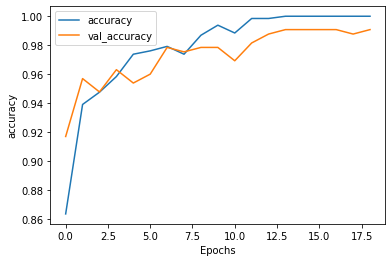

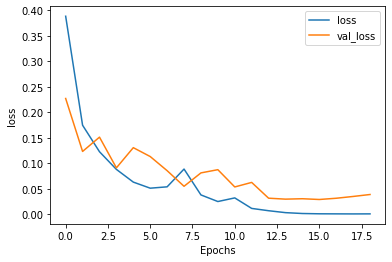

In [26]:
plot_graphs(history_rnn, 'accuracy')
plot_graphs(history_rnn, 'loss')

Normalized confusion matrix
[[0.99891186 0.00108814]
 [0.002849   0.997151  ]]


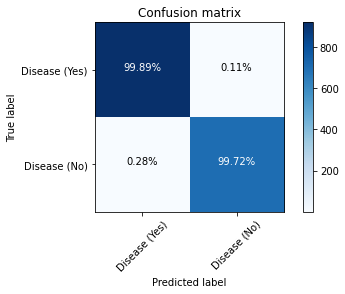

In [27]:
predictions_rnn = model.predict(x=X_test, verbose=0)

cm = confusion_matrix(y_true=Y_test, y_pred=np.round(predictions_rnn))
cm_plot_labels = ['Disease (Yes)', 'Disease (No)']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix', normalize= True)

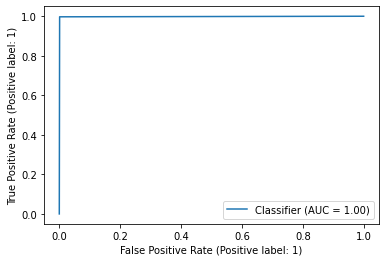

In [28]:
RocCurveDisplay.from_predictions(Y_test, np.round(predictions_rnn))

In [29]:
from sklearn import metrics

print(metrics.classification_report(Y_test, np.round(predictions_rnn), target_names=cm_plot_labels))

               precision    recall  f1-score   support

Disease (Yes)       1.00      1.00      1.00       919
 Disease (No)       1.00      1.00      1.00       702

     accuracy                           1.00      1621
    macro avg       1.00      1.00      1.00      1621
 weighted avg       1.00      1.00      1.00      1621



# Gated Recurrent Unit (GRU)
This is an improved version of the RNN model. It is more efficient than SimpleRNN models. It has two gates: reset and update. For this demonstration, I will replace the SimpleRNN layer with a bidirectional GRU layer with the same number of units.

In [11]:
model = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.GRU(units=50, return_sequences= True)),
    keras.layers.Dropout(0.2),
    keras.layers.Bidirectional(keras.layers.GRU(units=50, return_sequences= True)),
    keras.layers.Dropout(0.2),
    keras.layers.Bidirectional(keras.layers.GRU(units=50, return_sequences= True)),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.build(X_train.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (1621, 140, 100)         15900     
 l)                                                              
                                                                 
 dropout (Dropout)           (1621, 140, 100)          0         
                                                                 
 bidirectional_1 (Bidirectio  (1621, 140, 100)         45600     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (1621, 140, 100)          0         
                                                                 
 bidirectional_2 (Bidirectio  (1621, 140, 100)         45600     
 nal)                                                            
                                                        

In [12]:
callback = keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

history_gru = model.fit(x=X_train,y=Y_train, validation_split=0.20, batch_size=32, epochs=30, verbose=2, callbacks=[callback])

Epoch 1/30
41/41 - 17s - loss: 0.3814 - accuracy: 0.8434 - val_loss: 0.1591 - val_accuracy: 0.9446 - 17s/epoch - 425ms/step
Epoch 2/30
41/41 - 1s - loss: 0.1128 - accuracy: 0.9576 - val_loss: 0.1712 - val_accuracy: 0.9477 - 1s/epoch - 33ms/step
Epoch 3/30
41/41 - 1s - loss: 0.0690 - accuracy: 0.9745 - val_loss: 0.1171 - val_accuracy: 0.9723 - 1s/epoch - 33ms/step
Epoch 4/30
41/41 - 1s - loss: 0.0311 - accuracy: 0.9907 - val_loss: 0.0821 - val_accuracy: 0.9754 - 1s/epoch - 32ms/step
Epoch 5/30
41/41 - 1s - loss: 0.0158 - accuracy: 0.9961 - val_loss: 0.0858 - val_accuracy: 0.9846 - 1s/epoch - 33ms/step
Epoch 6/30
41/41 - 1s - loss: 0.0158 - accuracy: 0.9961 - val_loss: 0.0959 - val_accuracy: 0.9846 - 1s/epoch - 32ms/step
Epoch 7/30
41/41 - 1s - loss: 0.0052 - accuracy: 0.9977 - val_loss: 0.0665 - val_accuracy: 0.9815 - 1s/epoch - 33ms/step
Epoch 8/30
41/41 - 1s - loss: 0.0064 - accuracy: 0.9977 - val_loss: 0.0666 - val_accuracy: 0.9846 - 1s/epoch - 32ms/step
Epoch 9/30
41/41 - 1s - loss:

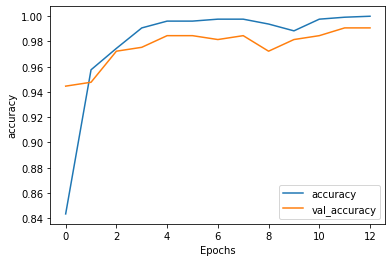

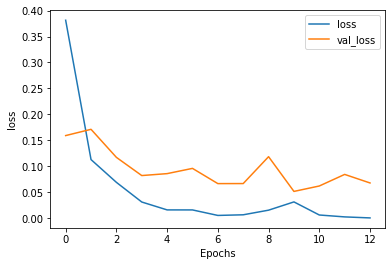

In [13]:
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

Normalized confusion matrix
[[0.99782372 0.00217628]
 [0.01566952 0.98433048]]


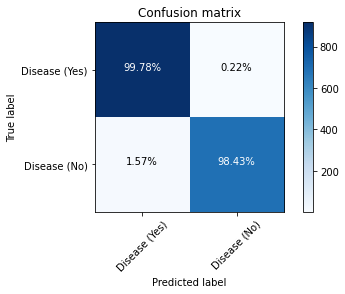

In [14]:
predictions_gru = model.predict(x=X_test, verbose=0)

cm = confusion_matrix(y_true=Y_test, y_pred=np.round(predictions_gru))
cm_plot_labels = ['Disease (Yes)', 'Disease (No)']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix', normalize= True)

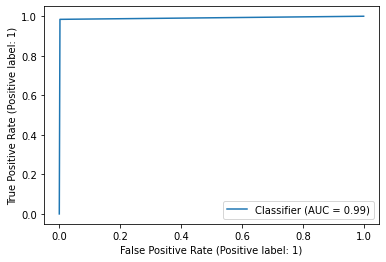

In [15]:
RocCurveDisplay.from_predictions(Y_test, np.round(predictions_gru))

In [16]:
from sklearn import metrics

print(metrics.classification_report(Y_test, np.round(predictions_gru), target_names=cm_plot_labels))

               precision    recall  f1-score   support

Disease (Yes)       0.99      1.00      0.99       919
 Disease (No)       1.00      0.98      0.99       702

     accuracy                           0.99      1621
    macro avg       0.99      0.99      0.99      1621
 weighted avg       0.99      0.99      0.99      1621



# Bidirectional LSTM

In [17]:
model = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(units=50, return_sequences= True)),
    keras.layers.Dropout(0.2),
    keras.layers.Bidirectional(keras.layers.LSTM(units=50, return_sequences= True)),
    keras.layers.Dropout(0.2),
    keras.layers.Bidirectional(keras.layers.LSTM(units=50, return_sequences= True)),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.build(X_train.shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (1621, 140, 100)         20800     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (1621, 140, 100)          0         
                                                                 
 bidirectional_4 (Bidirectio  (1621, 140, 100)         60400     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (1621, 140, 100)          0         
                                                                 
 bidirectional_5 (Bidirectio  (1621, 140, 100)         60400     
 nal)                                                            
                                                      

In [18]:
callback = keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

history_bi_lstm = model.fit(x=X_train,y=Y_train, validation_split=0.20, batch_size=32, epochs=30, verbose=2, callbacks=[callback])

Epoch 1/30
41/41 - 14s - loss: 0.4179 - accuracy: 0.8125 - val_loss: 0.2088 - val_accuracy: 0.9446 - 14s/epoch - 331ms/step
Epoch 2/30
41/41 - 2s - loss: 0.1190 - accuracy: 0.9591 - val_loss: 0.1850 - val_accuracy: 0.9415 - 2s/epoch - 38ms/step
Epoch 3/30
41/41 - 2s - loss: 0.0642 - accuracy: 0.9823 - val_loss: 0.0823 - val_accuracy: 0.9723 - 2s/epoch - 38ms/step
Epoch 4/30
41/41 - 2s - loss: 0.0201 - accuracy: 0.9923 - val_loss: 0.0719 - val_accuracy: 0.9785 - 2s/epoch - 38ms/step
Epoch 5/30
41/41 - 2s - loss: 0.0192 - accuracy: 0.9954 - val_loss: 0.0537 - val_accuracy: 0.9815 - 2s/epoch - 38ms/step
Epoch 6/30
41/41 - 2s - loss: 0.0139 - accuracy: 0.9969 - val_loss: 0.0464 - val_accuracy: 0.9908 - 2s/epoch - 37ms/step
Epoch 7/30
41/41 - 2s - loss: 0.0092 - accuracy: 0.9977 - val_loss: 0.0473 - val_accuracy: 0.9846 - 2s/epoch - 37ms/step
Epoch 8/30
41/41 - 2s - loss: 0.0096 - accuracy: 0.9969 - val_loss: 0.0677 - val_accuracy: 0.9754 - 2s/epoch - 37ms/step
Epoch 9/30
Restoring model we

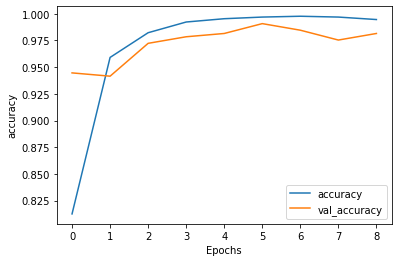

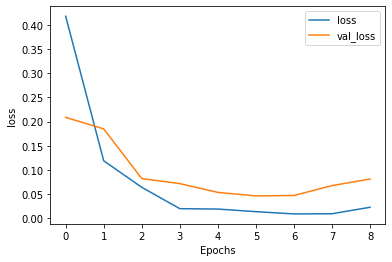

In [20]:
plot_graphs(history_bi_lstm, 'accuracy')
plot_graphs(history_bi_lstm, 'loss')

# Plot Confusion Matrix

Normalized confusion matrix
[[0.99673558 0.00326442]
 [0.002849   0.997151  ]]


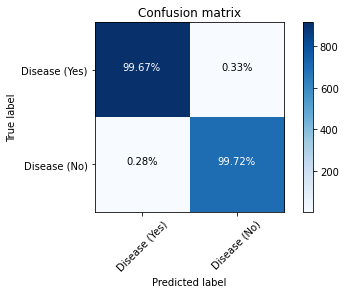

In [21]:
predictions_bi_lstm = model.predict(x=X_test, verbose=0)

cm = confusion_matrix(y_true=Y_test, y_pred=np.round(predictions_bi_lstm))
cm_plot_labels = ['Disease (Yes)', 'Disease (No)']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix', normalize= True)

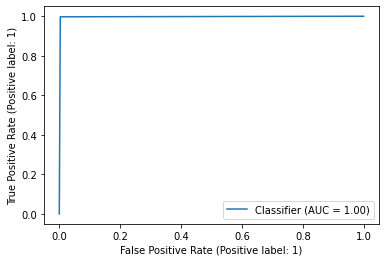

In [22]:
RocCurveDisplay.from_predictions(Y_test, np.round(predictions_bi_lstm))

# Model Evaluation

In [23]:
from sklearn import metrics

print(metrics.classification_report(Y_test, np.round(predictions_bi_lstm), target_names=cm_plot_labels))

               precision    recall  f1-score   support

Disease (Yes)       1.00      1.00      1.00       919
 Disease (No)       1.00      1.00      1.00       702

     accuracy                           1.00      1621
    macro avg       1.00      1.00      1.00      1621
 weighted avg       1.00      1.00      1.00      1621

